# Fitting remaining ion current conductances

Using full AP/CaT measures to fit the remaining conductances.

# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameter_sensitivity,
                           plot_regression_fit,
                           plot_parameters_kde,
                           plot_distance_weights)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Generate prior including ABC channel results

In [5]:
history = {'icat': History('sqlite:////storage/hhecm/cellrotor/chouston/results/icat-generic/hl-1_icat-generic.db'),
           'ical': History('sqlite:////storage/hhecm/cellrotor/chouston/results/ical-generic/hl-1_ical-generic.db'),
           'ina':  History('sqlite:////storage/hhecm/cellrotor/chouston/results/ina-generic/hl-1_ina-generic3000.db'),
           'ikr':  History('sqlite:////storage/hhecm/cellrotor/chouston/results/ikr-generic/hl-1_ikr-generic.db'),
           'ikur': History('sqlite:////storage/hhecm/cellrotor/chouston/results/ikur-generic/hl-1_ikur-generic.db'),
           'ito': History('sqlite:////storage/hhecm/cellrotor/chouston/results/ito-generic/hl-1_ito-generic.db'),
           'iha': History('sqlite:////storage/hhecm/cellrotor/chouston/results/iha-generic/hl-1_iha-generic.db'),
           'ik1': History('sqlite:////storage/hhecm/cellrotor/chouston/results/ik1-generic/hl-1_ik1-generic.db')}

In [6]:
run_ids = {'icat': 1, 'ical': 4, 'ina': 1, 'ikr': 2, 'ikur': 1, 'ito': 1, 'iha': 4, 'ik1': 1}

In [7]:
# Set to correct result (last ABC run in database).
for k,h in history.items():
    h.id = run_ids[k]

In [8]:
# Create a prior from each channel's ABC posterior
from pyabc.transition import MultivariateNormalTransition
class rv_normal_fit(MultivariateNormalTransition):
    def __init__(self, key):
        self.key = key
        super().__init__()
    
    def fit(self, X, w):
        X.columns = [self.key]
        super().fit(pd.DataFrame(X), w)
        
    def rvs(self):
        sample = super().rvs()
        return sample.values[0]
    
    def pdf(self, x):
        # wrap in pd.Series
        x = pd.Series({self.key: x})
        val = super().pdf(x)
        return val

In [9]:
# Add to priors
prior = {}
for k, h in history.items():
    df, w = h.get_distribution(m=0)
    for key in df.keys():
        dist = rv_normal_fit(k+'.'+key)
        dist.fit(pd.DataFrame(df[key]), w)
        prior[k+'.'+key] = dist

In [10]:
len(prior)

101

# Create full cell model for ABC

In [11]:
from channels.hl1 import hl1 as model

In [12]:
#model.sample({})

In [13]:
# Targets from Dias, 2014 from HL1-6 myocyte
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

In [14]:
measurements

,errs,exp,x,y
0,2.0,0,vrp,-67.0
1,2.0,0,apa,105.0
2,9.0,0,apd90,42.0
3,2.0,0,t_ca_rise,52.0
4,6.0,0,t_ca50,157.0
5,14.0,0,t_ca90,397.0


In [15]:
# Treat each entry as a separate experiment
for k, _ in exp.items():
    exp[k] = k

In [16]:
# Add additional parameters to be fit using full cell
# measurements as uniform priors.
limits = {'ik1.g_K1': (0, 0.1),
          'incx.k_NCX': (0, 20),
          'icab.g_Cab': (0, 0.001),
          'inab.g_Nab': (0, 0.01),
          'inak.i_NaK_max': (0, 10)}
          #'serca.V_max': (0, 10),
          #'ca_diffusion.tau_tr': (0, 1000)}
          #'ryanodine_receptors.k_RyR': (0, 0.1)}
for key, (a,b) in limits.items():
    prior[key] = RV("uniform", a, b-a)

In [17]:
len(prior)

105

In [18]:
prior = Distribution(**prior)

# Test parameter sensitivity

In [19]:
parameters = list(prior.keys())

In [20]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.01)

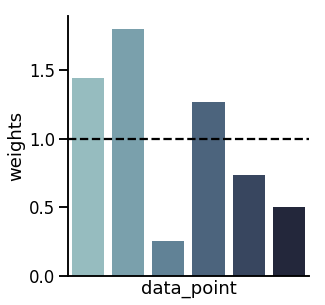

In [21]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)

In [22]:
print(distance_fn.w)

{0: {0: 1.4399578959706354, 1: 1.8026318567196629, 2: 0.2533521088894416, 3: 1.2685689115983454, 4: 0.7347523161155426, 5: 0.5007369107063717}}


In [23]:
g.savefig('results/extra-generic/dist_weights.pdf')

In [24]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.025,
    n_samples=5000)

In [25]:
# Finding insensitive parameters
cutoff = 0.25
fitted_pivot = fitted.pivot(index='param',columns='exp')
insensitive_params = fitted_pivot[(abs(fitted_pivot['beta'][0])<cutoff) & (abs(fitted_pivot['beta'][1])<cutoff) &
             (abs(fitted_pivot['beta'][2])<cutoff) & (abs(fitted_pivot['beta'][3])<cutoff) &
             (abs(fitted_pivot['beta'][4])<cutoff) & (abs(fitted_pivot['beta'][5])<cutoff)].index.values

In [26]:
# SAVE RESULTS
import pickle
with open('insensitive.pkl','wb') as f:
    pickle.dump(insensitive_params,f)

In [21]:
# LOAD RESULTS
import pickle
with open('insensitive.pkl','rb') as f:
    insensitive_params = pickle.load(f)

In [27]:
len(insensitive_params)

93

In [28]:
insensitive_params

array(['icab.g_Cab', 'ical.Vhalf_d', 'ical.Vhalf_f', 'ical.Vmax_d',
       'ical.Vmax_f', 'ical.c_ad', 'ical.c_af', 'ical.c_bd', 'ical.c_bf',
       'ical.ca_dep_fCa', 'ical.k_d', 'ical.k_f', 'ical.sigma_d',
       'ical.sigma_f', 'ical.tau_fCa', 'icat.Vhalf_g', 'icat.Vmax_b',
       'icat.Vmax_g', 'icat.c_ab', 'icat.c_ag', 'icat.c_bb', 'icat.c_bg',
       'icat.g_CaT', 'icat.k_g', 'icat.sigma_b', 'icat.sigma_g',
       'icat.v_offset', 'iha.Vmax_y', 'iha.c_ay', 'iha.c_by', 'iha.g_ha',
       'iha.k_i_haNa', 'iha.k_y', 'iha.sigma_y', 'ik1.k_x', 'ikr.Vhalf_A',
       'ikr.Vhalf_r', 'ikr.Vhalf_x', 'ikr.Vmax_r', 'ikr.Vmax_x',
       'ikr.c_ar', 'ikr.c_axf', 'ikr.c_axs', 'ikr.c_br', 'ikr.c_bxf',
       'ikr.c_bxs', 'ikr.g_Kr', 'ikr.k_A', 'ikr.k_r', 'ikr.k_x',
       'ikr.sigma_r', 'ikr.sigma_x', 'ikur.Vhalf_a', 'ikur.Vhalf_i',
       'ikur.Vmax_a', 'ikur.Vmax_i', 'ikur.c_aa', 'ikur.c_ai',
       'ikur.c_ba', 'ikur.c_bi', 'ikur.g_Kur', 'ikur.k_a', 'ikur.k_i',
       'ikur.sigma_a', 'ikur.si

In [29]:
insensitive_params = np.array([p for p in insensitive_params if p not in limits.keys()])

In [30]:
len(insensitive_params)

91

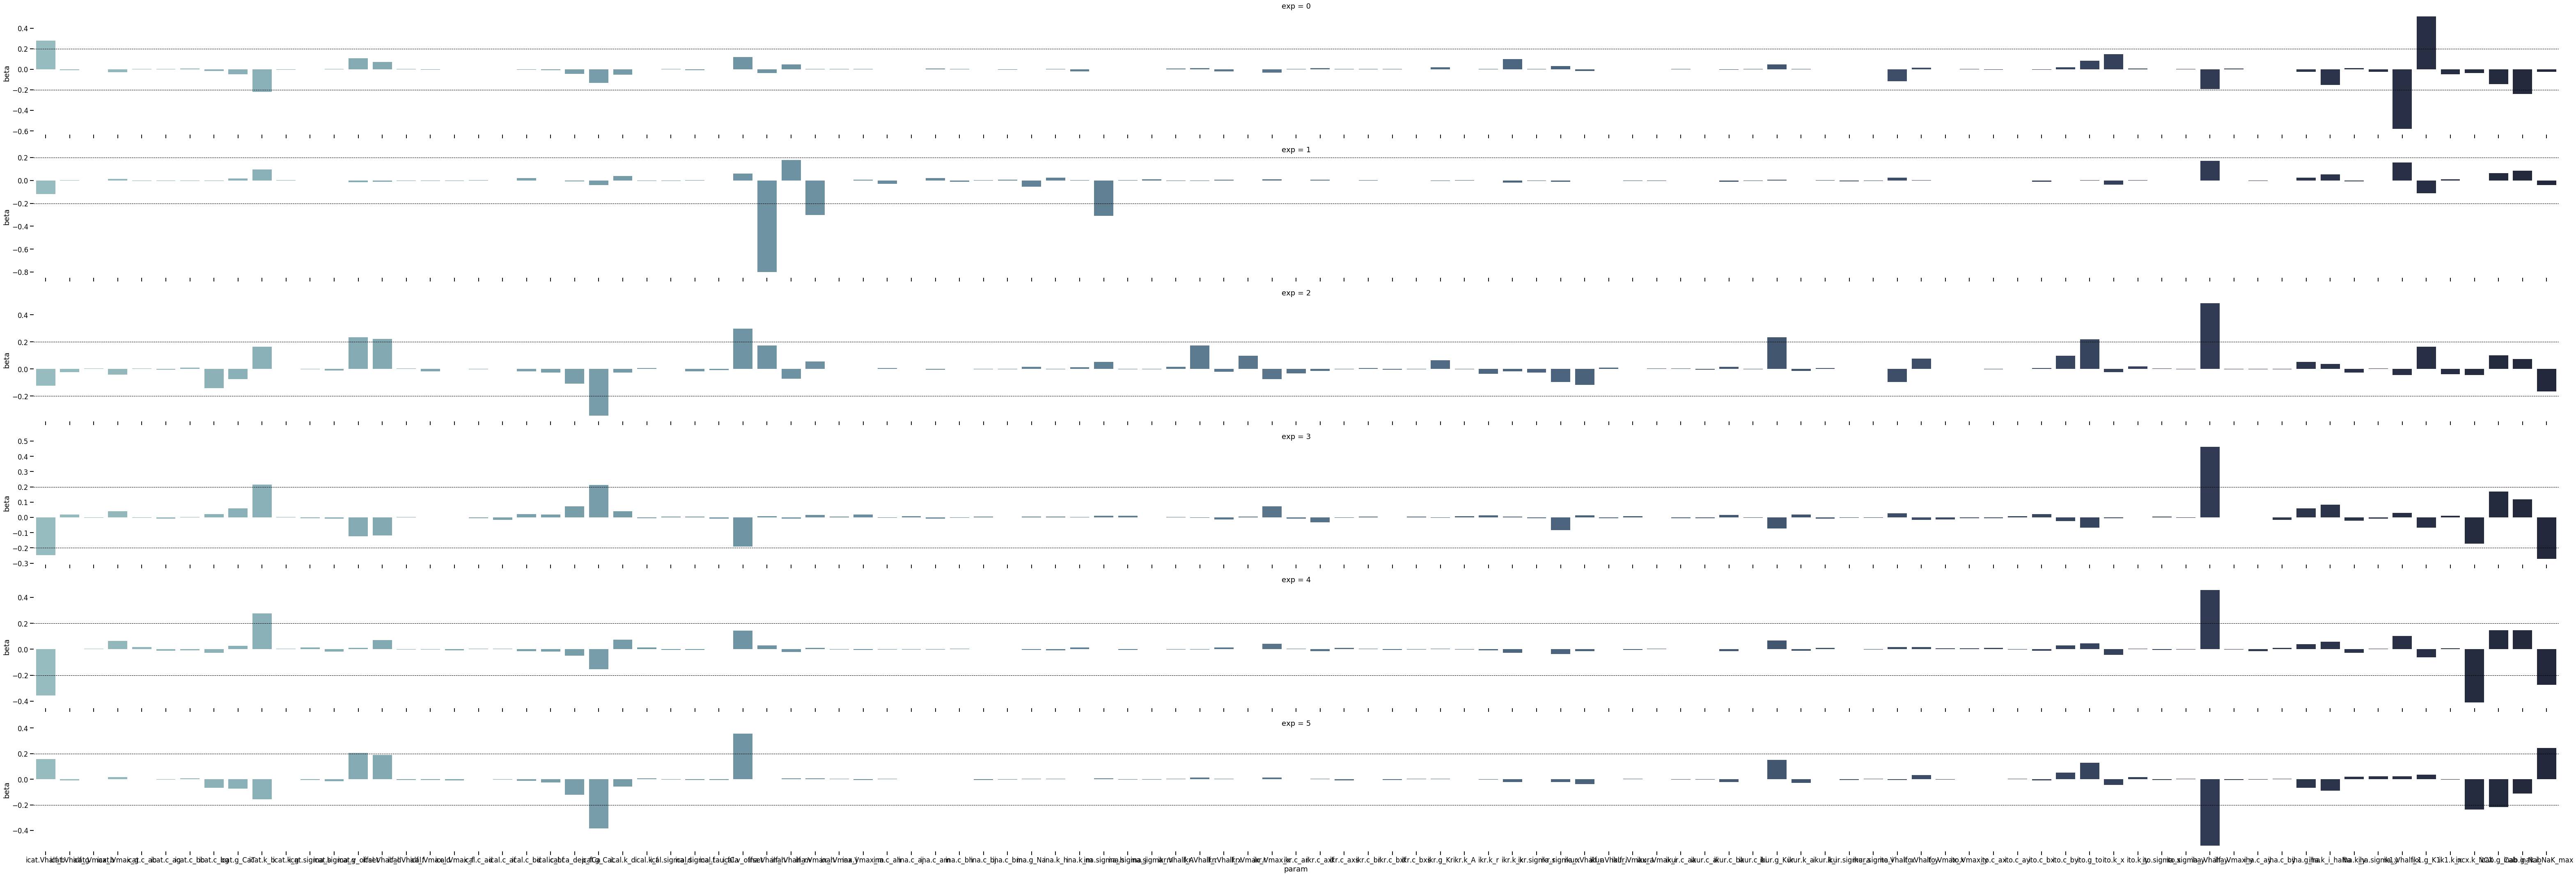

In [31]:
sns.set_context('talk')
grid = plot_parameter_sensitivity(fitted, plot_cutoff=0.2)

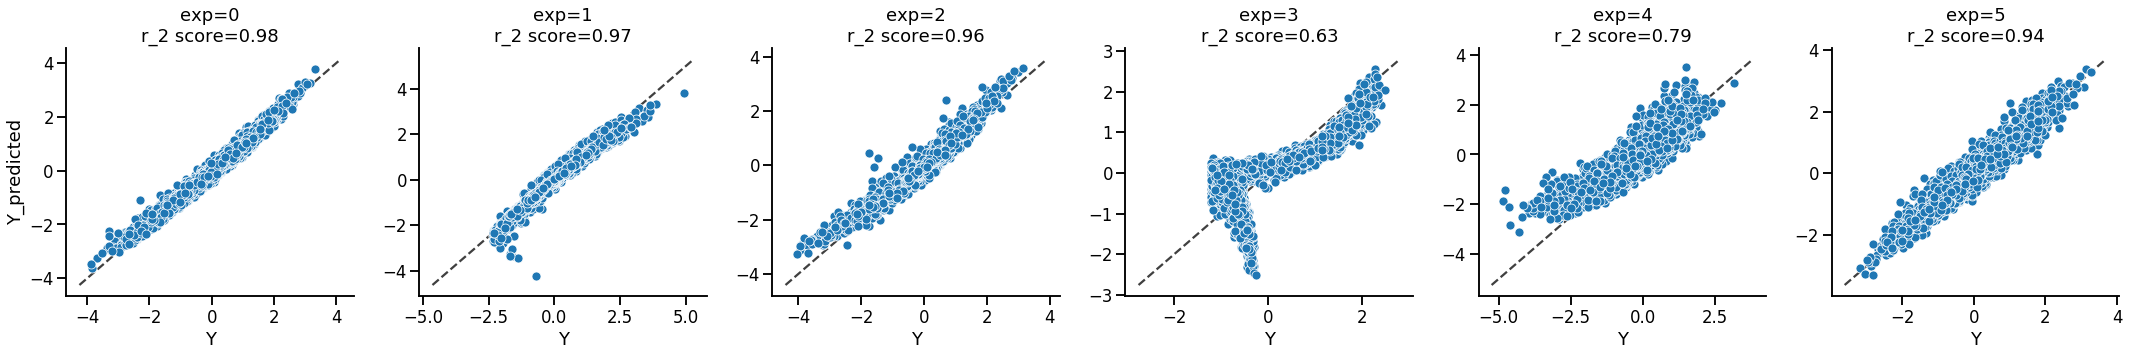

In [32]:
grid2 = plot_regression_fit(regression_fit, r2)

In [33]:
grid.savefig('results/extra-generic/sensitivity.pdf')
grid2.savefig('results/extra-generic/sensitivity_fit.pdf')

In [34]:
# Generate a sample from history items insensitive to full cell model measurements
def generate_sample(history, insensitive_params, n):
    samples = [dict() for i in range(n)]
    for k, h in history.items():
        dist = h.get_distribution(m=0)
        weights = dist[1]
        ch_samples = dist[0] \
                    .sample(n, weights=weights, replace=True) \
                    .to_dict(orient='records')
        ch_samples = [{k+'.'+key: value for key, value in ch.items()
                      if (k+'.'+key) in insensitive_params}
                      for ch in ch_samples]
        for c, s in zip(ch_samples, samples):
            s.update(c)
    return samples

In [35]:
# Generate samples
n_samples = 10000
param_samples = generate_sample(history, insensitive_params, n_samples)

In [36]:
model.add_external_par_samples(param_samples)

In [37]:
# New prior without insensitive parameters
prior = {}
for k, h in history.items():
    df, w = h.get_distribution(m=0)
    for key in df.keys():
        if (k+'.'+key) not in insensitive_params:
            dist = rv_normal_fit(k+'.'+key)
            dist.fit(pd.DataFrame(df[key]), w)
            prior[k+'.'+key] = dist

In [38]:
limits = {'ik1.g_K1': (0, 0.1),
          'incx.k_NCX': (0, 20),
          'icab.g_Cab': (0, 0.001),
          'inab.g_Nab': (0, 0.01),
          'inak.i_NaK_max': (0, 10)}
          #'serca.V_max': (0, 10),
          #'ca_diffusion.tau_tr': (0, 1000)}
          #'ryanodine_receptors.k_RyR': (0, 0.1)}
for key, (a,b) in limits.items():
    prior[key] = RV("uniform", a, b-a)

In [39]:
prior = Distribution(**prior)

In [40]:
prior

<Distribution 'icab.g_Cab', 'ical.g_CaL', 'ical.v_offset', 'icat.Vhalf_b', 'icat.k_b', 'iha.Vhalf_y', 'ik1.Vhalf_x', 'ik1.g_K1', 'ina.Vhalf_h', 'ina.Vmax_h', 'ina.sigma_h', 'inab.g_Nab', 'inak.i_NaK_max', 'incx.k_NCX'>

# Initialise database

In [41]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_extra-generic.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_extra-generic.db


In [42]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [43]:
from pyabc.sampler import SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [44]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.01),
             population_size=ConstantPopulationSize(5000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=5000,
             #    mean_cv=0.2,
             #    max_population_size=5000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(scaling=1.0),
             eps=MedianEpsilon(),#median_multiplier=1.5),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             #sampler=SingleCoreSampler(),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 1.4399578959706354, 1: 1.8026318567196629, 2: 0.2533521088894416, 3: 1.2685689115983454, 4: 0.7347523161155426, 5: 0.5007369107063717}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [45]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-12-18 16:36:10.238751, end_time=None)>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/ionchannelABC-0.1.0-py3.6.egg/ionchannelABC/ion_channel_pyabc.py:129: ResourceWarning: unclosed file <_io.TextIOWrapper name=60 mode='w+' encoding='UTF-8'>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/ionchannelABC-0.1.0-py3.6.egg/ionchannelABC/ion_channel_pyabc.py:129: ResourceWarning: unclosed file <_io.TextIOWrapper name=61 mode='w+' encoding='UTF-8'>
INFO:Epsilon:initial epsilon is 129.2521529036781


In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10, min_acceptance_rate=0.001)

INFO:ABC:t:0 eps:129.2521529036781
DEBUG:ABC:now submitting population 0
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/ionchannelABC-0.1.0-py3.6.egg/ionchannelABC/ion_channel_pyabc.py:129: ResourceWarning: unclosed file <_io.TextIOWrapper name=60 mode='w+' encoding='UTF-8'>
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 13973
DEBUG:Epsilon:new eps, t=1, eps=80.20018541391336
INFO:ABC:t:1 eps:80.20018541391336
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 26741
DEBUG:Epsilon:new eps, t=2, eps=58.76278931337524
INFO:ABC:t:2 eps:58.76278931337524
DEBUG:ABC:now submitting population 2


In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=5, min_acceptance_rate=0.001)

In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=5, min_acceptance_rate=0.001)

In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=5, min_acceptance_rate=0.001)

In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=5, min_acceptance_rate=0.001)

# Results analysis

In [48]:
#db_path = 'sqlite:///results/extra/hl-1_extra.db'
db_path = 'sqlite:////scratch/cph211/tmp/hl-1_extra-generic.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-12-18 16:36:10.238751, end_time=2018-12-19 02:47:34.113780)>]

In [64]:
#history.id = 15 # run with err=0.1 and scaling=0.25
#history.id = 17 # run with err=0.01 and scaling=0.5
#history.id = 23 # run with new icat channel fitting using v_offset and no ion concentrations
#history.id = 24 # run with new icat channel fitting using v_offset, no ion concentrations and no APA
history.id = 1

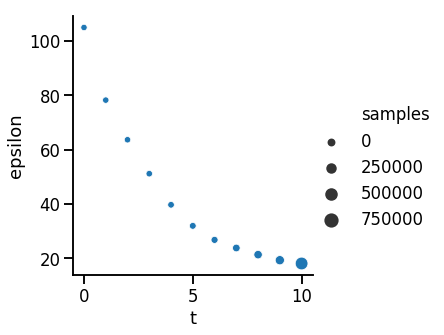

In [65]:
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
#grid.savefig('results/extra/eps_evolution.pdf')

In [66]:
df_prior, w_prior = history.get_distribution(m=0,t=0)

In [67]:
df_extra = df_prior.loc[:,[k for k in prior.keys()]]

In [68]:
for c in df_extra.columns:
    if c not in limits.keys():
        limits[c] = (df_extra[c].min(), df_extra[c].max())

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


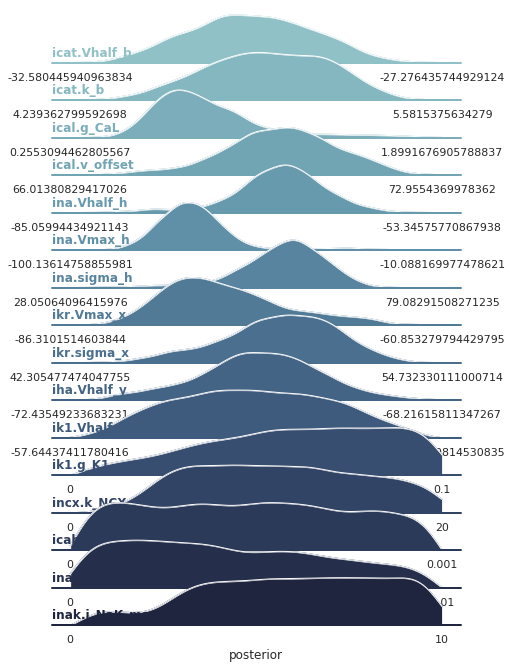

In [69]:
g = plot_parameters_kde(df_extra, w_prior, limits, aspect=12, height=0.6)

In [138]:
g.savefig('results/extra/parameters_kde_prior.pdf')

In [70]:
df, w = history.get_distribution(m=0)

In [71]:
df_extra = df.loc[:,[k for k in prior.keys()]]

In [72]:
limits

{'ik1.g_K1': (0, 0.1),
 'incx.k_NCX': (0, 20),
 'icab.g_Cab': (0, 0.001),
 'inab.g_Nab': (0, 0.01),
 'inak.i_NaK_max': (0, 10),
 'icat.Vhalf_b': (-32.580445940963834, -27.276435744929124),
 'icat.k_b': (4.239362799592698, 5.5815375634279),
 'ical.g_CaL': (0.2553094462805567, 1.8991676905788837),
 'ical.v_offset': (66.01380829417026, 72.9554369978362),
 'ina.Vhalf_h': (-85.05994434921143, -53.34575770867938),
 'ina.Vmax_h': (-100.13614758855981, -10.088169977478621),
 'ina.sigma_h': (28.05064096415976, 79.08291508271235),
 'ikr.Vmax_x': (-86.3101514603844, -60.853279794429795),
 'ikr.sigma_x': (42.305477474047755, 54.732330111000714),
 'iha.Vhalf_y': (-72.43549233683231, -68.21615811347267),
 'ik1.Vhalf_x': (-57.64437411780416, -56.753490814530835)}

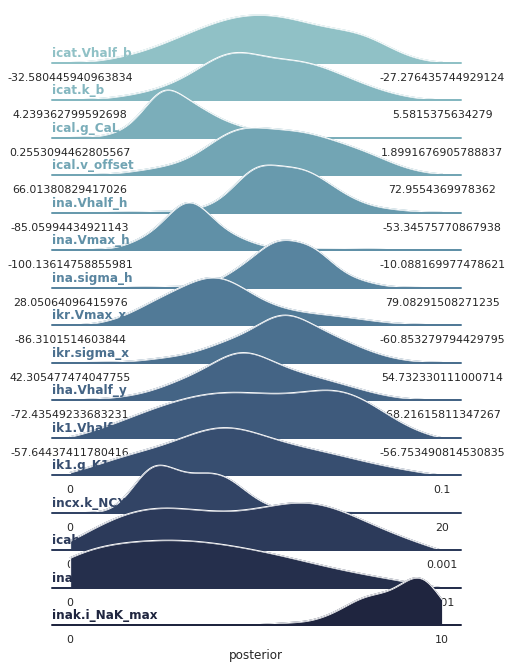

In [73]:
g = plot_parameters_kde(df_extra, w, limits, aspect=12, height=0.6)

In [143]:
g.savefig('results/extra/parameters_kde_post.pdf')

# Samples for quantitative analysis

In [74]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [75]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


# Evaluate results

In [76]:
import scipy.stats as st
def evaluate_samples(samples):
    for measurement in samples['x'].unique():
        filtered = samples[samples.x==measurement]['y'].tolist()
        print("{}, mean: {}".format(measurement, np.mean(filtered)))
        print("{}, STD:  {}".format(measurement, np.std(filtered)))
        rv = st.rv_discrete(values=(filtered, [1/len(filtered),]*len(filtered)))
        print("{}, median: {}".format(measurement, rv.median()))
        print("{}, 95% CI: {}".format(measurement, rv.interval(0.95)))

In [77]:
evaluate_samples(samples)

vrp, mean: -73.36355970737452
vrp, STD:  5.427551664897853
vrp, median: -74.67393236933015
vrp, 95% CI: (-78.81734636305603, -56.32702828950575)
apa, mean: 97.813998261176
apa, STD:  9.481457104740477
apa, median: 99.53088327488776
apa, 95% CI: (73.85148639898068, 113.47550270261378)
apd90, mean: 70.93950942138704
apd90, STD:  58.71594406509625
apd90, median: 62.52725683741404
apd90, 95% CI: (43.13724023396416, 121.18954955184988)
t_ca_rise, mean: 71.18812611116138
t_ca_rise, STD:  58.62926178159162
t_ca_rise, median: 60.94548839353956
t_ca_rise, 95% CI: (40.18202158780436, 127.40000819476943)
t_ca50, mean: 178.18414767343637
t_ca50, STD:  62.713018655169265
t_ca50, median: 169.84790130781144
t_ca50, 95% CI: (124.56268567437239, 236.95790009839195)
t_ca90, mean: 406.88248971610614
t_ca90, STD:  109.41515223597217
t_ca90, median: 391.8715041785202
t_ca90, 95% CI: (263.72305768312486, 670.9209309277552)


## Plot sample of voltage traces

In [78]:
from ionchannelABC import (Experiment, ExperimentStimProtocol)

In [79]:
# Create new experiment to generate traces
pulses = range(5, 45, 5)
stim_times = [1000000] + [2, 4998]*len(pulses)
stim_levels = [0]
for level in pulses:
    stim_levels.append(level)
    stim_levels.append(0)
#pace_time = np.linspace(0, 10000, 10000)
pace_time = np.linspace(0, sum(stim_times[1:]), sum(stim_times[1:]))

def trace_measurements(data_list):
    import numpy as np
    data = data_list[0]
    if len(data_list) > 1:
        for log in data_list[1:]:
            data = data.extend(log)
    simtime = data['environment.time']
    simtime_min = min(simtime)
    simtime = [t - simtime_min for t in simtime]
    data_output = dict()
    data['environment.time'] = simtime
    for var in data:
        data_output[var] = np.interp(pace_time, simtime, data[var])
    return data_output
def unwrap(data, ind_var):
    return data[0], True

trace_prot = ExperimentStimProtocol(stim_times, stim_levels, 
                                    #measure_index=range(len(stim_times)-4, len(stim_times)),
                                    measure_index=range(1, len(stim_times)),
                                    measure_fn=trace_measurements,
                                    post_fn=unwrap)
dias_conditions = dict(T=305, Ca_o=1800, Na_o=1.4e5, K_o=4e3)
trace_exper = Experiment(trace_prot, None, dias_conditions)

In [80]:
from channels.hl1 import hl1 as model_testing

In [81]:
model_testing.add_experiments([trace_exper])

In [82]:
# Generate traces
traces = pd.DataFrame({})
for i, th in enumerate(th_samples[0:10]):
    output = model_testing.sample(pars=th,exp_num=1)
    output['sample'] = i
    traces = traces.append(output, ignore_index=True)

In [145]:
import pickle
with open('traces.pkl','wb') as f:
    pickle.dump(traces, f)

In [37]:
import pickle
with open('traces.pkl','rb') as f:
    traces = pickle.load(f)

In [83]:
traces.x.unique()

array(['membrane.V', 'ina.m', 'ina.h', 'ina.j', 'ikr.x', 'ikr.r',
       'ikur.a', 'ikur.i', 'ito.x', 'ito.y', 'iha.y', 'icat.b', 'icat.g',
       'ical.d', 'ical.f', 'ical.fCa', 'ryanodine_receptors.P_open',
       'ca_conc_sr.Ca_SRuptake', 'ca_conc_sr.Ca_SRrelease',
       'ca_conc.Ca_i', 'na_conc.Na_i', 'k_conc.K_i', 'environment.time',
       'na_conc.E_Na', 'k_conc.E_K', 'ina.G_Na', 'ina.i_Na', 'ina.mss',
       'ina.tau_m', 'ina.hss', 'ina.tau_h', 'ina.jss', 'ina.tau_j',
       'ikr.G_Kr', 'ikr.i_Kr', 'ikr.xss', 'ikr.tau_x', 'ikr.rss',
       'ikr.tau_r', 'ikur.G_Kur', 'ikur.i_Kur', 'ikur.ass', 'ikur.tau_a',
       'ikur.iss', 'ikur.tau_i', 'ito.G_to', 'ito.i_to', 'ito.xss',
       'ito.tau_x', 'ito.yss', 'ito.tau_y', 'iha.G_ha', 'iha.i_haNa',
       'iha.i_haK', 'iha.i_ha', 'iha.yss', 'iha.tau_y', 'icat.G_CaT',
       'icat.i_CaT', 'icat.bss', 'icat.tau_b', 'icat.gss', 'icat.tau_g',
       'ical.i_CaL', 'ical.G_CaL', 'ical.dss', 'ical.tau_d', 'ical.fss',
       'ical.tau_f', 'ic

In [84]:
time = traces[traces.x=='environment.time'].y.tolist()[0]

In [85]:
#plotlims = (4950, 5400)
plotlims = [(4950+5000*i,5400+5000*i) for i in range(7)]

In [86]:
#idxlims = np.intersect1d(np.where(time >= plotlims[0]), np.where(time <= plotlims[1]))
idxlims = [np.intersect1d(np.where(time >= plotlims[i][0]), np.where(time <= plotlims[i][1]))
           for i in range(7)]

In [87]:
#time_limited = time[idxlims[0]:idxlims[-1]]
time_limited = time[idxlims[0][0]:idxlims[0][-1]]

In [88]:
traces = traces.set_index(['x','sample'])

In [89]:
del traces['exp']

In [90]:
traces.reset_index(inplace=True)

In [91]:
rows = []

In [92]:
#_ = traces.apply(lambda row: [rows.append([row['x'], row['sample'], yi, ti])
#                              for (ti, yi) in zip(time_limited, row.y[idxlims[0]:idxlims[-1]])], axis=1)
for i in range(7):
    _ = traces.apply(lambda row: [rows.append([row['x'], row['sample']+10*i, yi, ti])
                                  for (ti, yi) in zip(time_limited, row.y[idxlims[i][0]:idxlims[i][-1]])], axis=1)

In [93]:
traces_new = pd.DataFrame(rows, columns=['x', 'sample', 'y', 'time']).set_index(['x', 'sample'])

In [94]:
traces_new.reset_index(inplace=True)

In [95]:
no_ap_samples = []

In [96]:
for i in range(max(traces_new['sample'])):
    if max(traces_new[(traces_new['sample']==i) & (traces_new['x']=='membrane.V')]['y']) < 0:
        no_ap_samples.append(i)

In [97]:
no_ap_samples

[5]

In [98]:
for val in no_ap_samples:
    traces_new = traces_new[~(traces_new['sample']==val)]

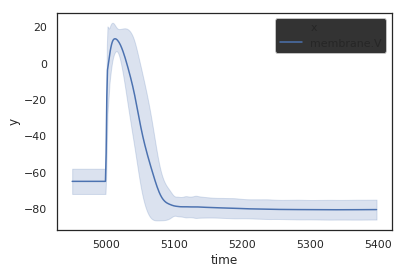

In [100]:
plot = sns.lineplot(x='time',y='y',hue='x',
                    data=traces_new[(traces_new.x=='membrane.V')],
                    estimator=np.mean, ci='sd')

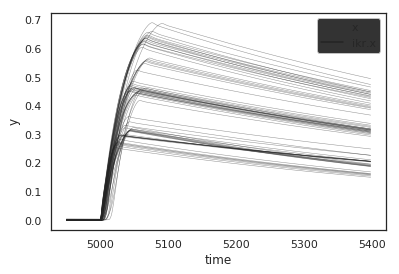

In [108]:
with sns.color_palette('gray'):
    plot = sns.lineplot(x='time',y='y',hue='x',units='sample',
                        data=traces_new[(traces_new.x=='ikr.x')],
                        estimator=None,lw=0.5,alpha=0.5)

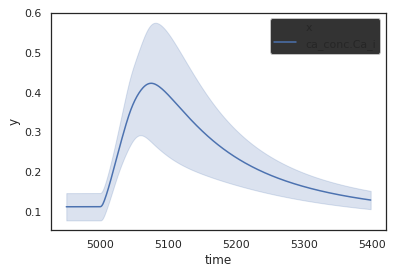

In [102]:
plot = sns.lineplot(x='time',y='y',hue='x',
                    data=traces_new[(traces_new.x=='ca_conc.Ca_i')],
                    estimator=np.mean, ci='sd')

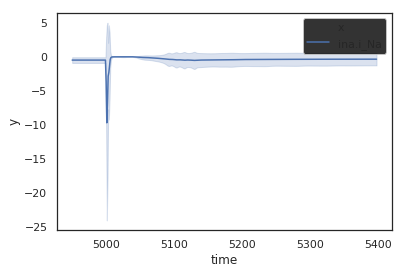

In [103]:
plot = sns.lineplot(x='time',y='y',hue='x',
                    data=traces_new[(traces_new.x=='ina.i_Na')],
                    estimator=np.mean, ci='sd')

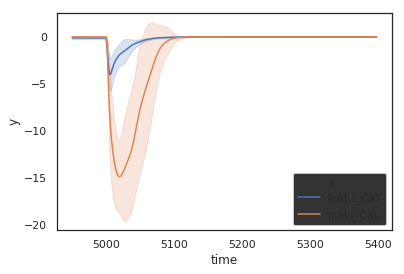

In [104]:
plot = sns.lineplot(x='time',y='y',hue='x',
                    data=traces_new[(traces_new.x=='ical.i_CaL') | (traces_new.x=='icat.i_CaT')],
                    estimator=np.mean, ci='sd')

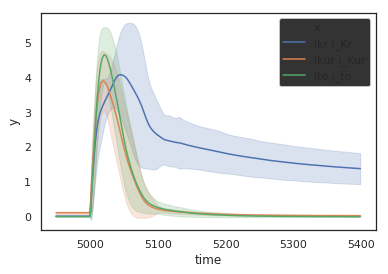

In [105]:
plot = sns.lineplot(x='time',y='y',hue='x',
                    data=traces_new[(traces_new.x=='ikr.i_Kr') | (traces_new.x=='ikur.i_Kur') |
                                    (traces_new.x=='ito.i_to')],
                    estimator=np.mean, ci='sd')

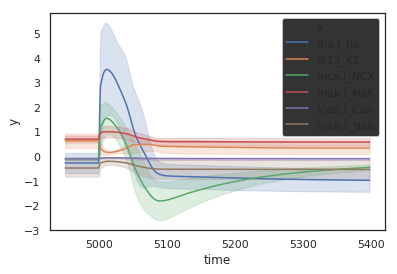

In [106]:
plot = sns.lineplot(x='time',y='y',hue='x',
                    data=traces_new[(traces_new.x=='ik1.i_K1') | (traces_new.x=='incx.i_NCX') |
                                    (traces_new.x=='inak.i_NaK') | (traces_new.x=='iha.i_ha') |
                                    (traces_new.x=='inab.i_Nab') | (traces_new.x=='icab.i_Cab')],
                    estimator=np.mean, ci='sd')

In [193]:
fig = plot.get_figure()
fig.savefig('results/extra/small_currents.pdf')

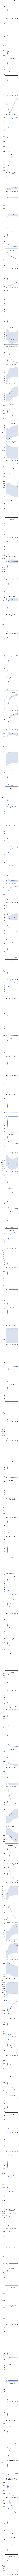

In [225]:
grid = sns.relplot(x='time', y='y', data=traces_new, row='x',
                   estimator=np.median, ci=95, kind='line',
                   facet_kws={'sharex': 'row',
                              'sharey': False})

## Test for specific modes of AP model

In [49]:
samp_pivot = samples.pivot(index='sample', columns='x', values='y')

In [50]:
from sklearn.cluster import AffinityPropagation

In [51]:
af = AffinityPropagation()

In [52]:
af.fit(samp_pivot.values)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [53]:
centers = pd.DataFrame(af.cluster_centers_, columns=samp_pivot.columns)

In [55]:
af.cluster_centers_indices_

array([  32,   45,  334,  576,  618,  644,  769,  796,  938,  964, 1000,
       1056, 1062, 1122, 1130, 1182, 1238, 1244, 1258, 1263, 1276, 1289,
       1331, 1394, 1475, 1509, 1589, 1604, 1642, 1688, 1703, 1736, 1899,
       1905, 1965, 1971, 2006, 2068, 2082, 2102, 2134, 2137, 2141, 2220,
       2328, 2412, 2451, 2642, 2700, 2746, 2754, 2770, 2842, 2853, 2864,
       2925, 2963, 3027, 3028, 3029, 3083, 3093, 3242, 3264, 3377, 3385,
       3433, 3534, 3551, 3575, 3606, 3691, 3840, 3865, 3870, 4001, 4016,
       4043, 4115, 4121, 4248, 4282, 4351, 4360, 4406, 4410, 4431, 4595,
       4632, 4683, 4695, 4701, 4784])

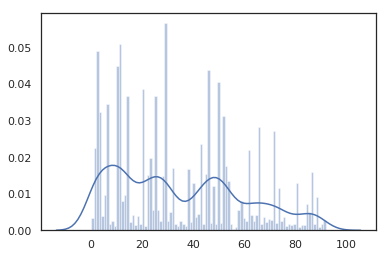

In [56]:
sns.distplot(af.labels_, bins=len(af.cluster_centers_))